In [1]:
import pandas as pd
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import BernoulliNB 
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

In [2]:
import warnings
warnings.simplefilter("ignore", DeprecationWarning)
# Load the LDA model from sk-learn
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.cluster import KMeans 
from sklearn.metrics import f1_score

In [3]:
import pickle

In [4]:
from nltk.corpus import stopwords 

In [5]:
import spacy
from spacy import displacy
from collections import Counter
import en_core_web_sm
from spacy.pipeline import merge_entities
nlp = en_core_web_sm.load()
nlp.add_pipe(merge_entities)

In [48]:
# files = ['non_relevant_aadhar.txt',
#          'relevant_aadhar.txt',
#         'non_relevant_demon.txt',
#           'relevant_demon.txt',
#         'non_relevant_farmers.txt',
#          'relevant_farmers.txt',
#         'non_relevant_gst.txt',
#         'relevant_gst.txt']
# files = ['non_relevant_farmers.txt',
#          'relevant_farmers.txt']

In [49]:
def replace_entity(sent):
    doc = nlp(sent)
    for ent in doc.ents:
        if ent.label_=='PERSON':
#             sent = sent.replace(ent.text,ent.label_)
            sent = sent.replace(ent.text, "")
    return sent

In [50]:
file_sents = []
labels = []
for i, file in enumerate(files):
    with open(file,'r') as f:
        lines = f.readlines()
        file_sents+=[l.strip() for l in lines]
        labels+=[i]*len(lines)

# for file in files:
#     with open(file, 'r') as f:
#         lines = f.readlines()
#         file_sents.append("\n".join(lines))

# df = pd.DataFrame({"file":files,"text":file_sents})
df = pd.DataFrame({"text":file_sents, "label":labels})
# Remove punctuation
df['text_processed'] = df['text'].map(lambda x: re.sub('[,\.!?|;]', ' ', x))
df['text_processed'] = df['text_processed'].map(lambda x: re.sub('[0-9]', ' ', x))
# remove person entity
df['text_processed'] = df['text_processed'].map(lambda x: replace_entity(x))
# Convert the titles to lowercase
df['text_processed'] = df['text_processed'].map(lambda x: x.lower())

In [51]:
df.head()

,text,label,text_processed
0,;;0.1779;;the cm claimed that shiv sena chief ...,0,the cm claimed that shiv sena chief ...
1,;;-0.7717;;fadnavis said the situation was vol...,0,- fadnavis said the situation was vol...
2,";;0.0772;;however, they did not submit their l...",0,however they did not submit their l...
3,";;0.5574;;speaking in the legislative council,...",0,speaking in the legislative council ...
4,;;0.5574;;we are positive about withdrawing th...,0,we are positive about withdrawing th...


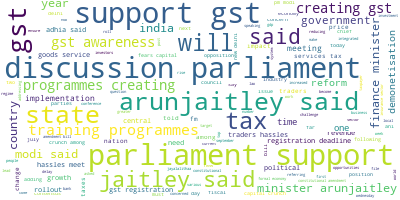

In [10]:
# Join the different processed titles together.
long_string = ','.join(list(df['text_processed'].values))
# print(df['file'][7])
# long_string = df['text_processed'][7]

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(long_string)

# Visualize the word cloud
wordcloud.to_image()

In [52]:
# # Helper function
# def plot_10_most_common_words(count_data, count_vectorizer):
#     import matplotlib.pyplot as plt
#     words = count_vectorizer.get_feature_names()
#     total_counts = np.zeros(len(words))
#     for t in count_data:
#         total_counts+=t.toarray()[0]
    
#     count_dict = (zip(words, total_counts))
#     count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
#     words = [w[0] for w in count_dict]
#     counts = [w[1] for w in count_dict]
#     x_pos = np.arange(len(words)) 
    
#     plt.figure(2, figsize=(15, 15/1.6180))
#     plt.subplot(title='10 most common words')
#     sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
#     sns.barplot(x_pos, counts, palette='husl')
#     plt.xticks(x_pos, words, rotation=90) 
#     plt.xlabel('words')
#     plt.ylabel('counts')
#     plt.show()

# Initialise the count vectorizer with the English stop words
# count_vectorizer = CountVectorizer()
count_vectorizer = TfidfVectorizer(ngram_range=(1,3), stop_words=set(stopwords.words('english')))
# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(df['text_processed'])

# Visualise the 10 most common words
# plot_10_most_common_words(count_data, count_vectorizer)


In [53]:
count_data.shape

(331, 10076)

In [54]:
pickle.dump(count_vectorizer, open('farmers_vectorizer_3.pickle','wb'))
pickle.dump(count_data, open('farmers_X_3.pickle','wb'))

In [43]:
# Helper function
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
# Tweak the two parameters below (use int values below 15)
number_topics = 2
number_words = 10

# Create and fit the LDA model
lda = LDA(n_components=number_topics)
lda.fit(count_data)

# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, count_vectorizer, number_words)

# kmeans = KMeans(n_clusters=2)
# kmeans.fit(count_data)

Topics found via LDA:

Topic #0:
parliament support discussion gst modi said traders jaitley deadline hassles

Topic #1:
gst said tax arunjaitley would minister creating programmes training awareness


In [44]:
for i in range(len(df)):
    pred = lda.transform(count_vectorizer.transform([df['text_processed'][i]])).tolist()[0]
    topic = pred.index(max(pred))
    print(topic, df['label'][i])

1 0
1 0
1 0
0 0
0 0
0 0
0 0
0 0
1 0
1 0
1 0
1 0
0 0
0 0
1 0
0 0
0 0
0 0
0 0
1 0
0 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
0 0
0 0
1 0
1 0
1 0
0 0
0 0
1 0
1 0
0 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
0 0
0 0
1 0
1 0
0 0
0 0
1 0
1 0
0 0
0 0
0 0
0 0
0 1
0 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
0 1
0 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
0 1
0 1
0 1
1 1
1 1
1 1
1 1
1 1
1 1
0 1


In [45]:
pickle.dump(lda, open('lda_gst_model.pickle', 'wb'), protocol=pickle.HIGHEST_PROTOCOL)
pickle.dump({"relevant":1, "non-relevant":0}, open('lda_gst_dict.pickle','wb'))
pickle.dump(count_vectorizer, open('lda_gst_vectorizer.pickle','wb'))

In [ ]:
# y_pred = kmeans.predict(count_data)
# clf = SVC()
clf = BernoulliNB()
clf.fit(count_data, df['label'])
y_pred = clf.predict(count_data)

In [ ]:
y_pred

In [ ]:
clf.score(count_data,df['label'])

In [ ]:
f1_score(df['label'],y_pred)

In [ ]:
x = count_data.todense()

In [ ]:
data2D = TSNE(n_components=2).fit_transform(x)
# pca = PCA(n_components=2).fit(x)
# data2D = pca.transform(x)

In [ ]:
# centers2D = pca.transform(kmeans.cluster_centers_)
# plt.hold(True)
plt.scatter(data2D[:,0], data2D[:,1], c=df.label, edgecolor='k')
# plt.scatter(centers2D[:,0], centers2D[:,1], 
#             marker='x', s=200, linewidths=3, c='b')
plt.show

In [ ]:
plt.scatter(data2D[:,0], data2D[:,1], c=y_pred, edgecolor='k')
plt.show() 

In [ ]:
for i,y in enumerate(y_pred):
    if y==1:
        print(df['text_processed'][i])

In [ ]:
# %%time

# from pyLDAvis import sklearn as sklearn_lda
# import pickle 
# import pyLDAvis
# import os

# # Visualize the topics
# pyLDAvis.enable_notebook()

# LDAvis_data_filepath = os.path.join('./ldavis_prepared_'+str(number_topics))
# # # this is a bit time consuming - make the if statement True
# # # if you want to execute visualization prep yourself
# if 1 == 1:

#     LDAvis_prepared = sklearn_lda.prepare(lda, count_data, count_vectorizer)

#     with open(LDAvis_data_filepath, 'w') as f:
#         pickle.dump(LDAvis_prepared, f)
        
# # load the pre-prepared pyLDAvis data from disk
# with open(LDAvis_data_filepath) as f:
#     LDAvis_prepared = pickle.load(f)

# pyLDAvis.save_html(LDAvis_prepared, './ldavis_prepared_'+ str(number_topics) +'.html')

# LDAvis_prepared